# Comparing three face verifiers which are trained using Binary Cross-Entropy loss, contrastive loss and triplet loss, receptively.

# Contrastive Loss

## Setup

In [ ]:

#!unzip -q "/content/drive/MyDrive/Datasets/archive.zip" -d /content/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras import ops

## Hyperparameters and File Paths

In [ ]:
epochs = 20
batch_size = 16
margin = 1

TARGET_SHAPE = (128, 128)

IMAGE_DIR = "/content/lfw-deepfunneled/lfw-deepfunneled"
PAIRS_FILE ="/content/pairs.csv"

## Load LFW Data and Create Pairs

In [ ]:
def load_and_create_pairs_from_lfw(image_dir, pairs_path, target_shape):
    """
    Parses the LFW pairs file, loads all images into memory, and creates
    positive and negative pairs as NumPy arrays.
    """
    pairs = []
    labels = []

    # --- Step 1: Parse the pairs file to get file paths ---
    positive_paths = []
    negative_paths = []
    with open(pairs_path, 'r') as f:
        next(f)  # Skip header
        for line in f.readlines():
            parts = line.strip().split(',')
            if len(parts) == 3 or (len(parts) == 4 and parts[3] == ''):
                p1, n1, n2 = parts[0], int(parts[1]), int(parts[2])
                path1 = os.path.join(image_dir, p1, f"{p1}_{n1:04d}.jpg")
                path2 = os.path.join(image_dir, p1, f"{p1}_{n2:04d}.jpg")
                positive_paths.append([path1, path2])
            elif len(parts) == 4:
                p1, n1, p2, n2 = parts[0], int(parts[1]), parts[2], int(parts[3])
                path1 = os.path.join(image_dir, p1, f"{p1}_{n1:04d}.jpg")
                path2 = os.path.join(image_dir, p2, f"{p2}_{n2:04d}.jpg")
                negative_paths.append([path1, path2])

    all_path_pairs = positive_paths + negative_paths
    all_labels = [0] * len(positive_paths) + [1] * len(negative_paths)

    # --- Step 2: Load images from paths into NumPy arrays ---
    print(f"Loading {len(all_path_pairs) * 2} images into memory...")
    for i in range(len(all_path_pairs)):
        try:
            path1, path2 = all_path_pairs[i]

            # Load and process image 1
            img1 = Image.open(path1).convert("RGB").resize(target_shape)
            img1_array = np.array(img1, dtype="float32")

            # Load and process image 2
            img2 = Image.open(path2).convert("RGB").resize(target_shape)
            img2_array = np.array(img2, dtype="float32")

            pairs.append([img1_array, img2_array])
            labels.append(all_labels[i])
        except FileNotFoundError:
            #print(f"Warning: Could not find one or both images for pair {i}. Skipping.")
            continue

    print("Image loading complete.")
    return np.array(pairs), np.array(labels, dtype="float32")

# --- This is the new splitting logic that follows the blog's strategy ---

# This will take significant time and memory
all_pairs, all_labels = load_and_create_pairs_from_lfw(IMAGE_DIR, PAIRS_FILE, TARGET_SHAPE)

# Shuffle the data before splitting
p = np.random.permutation(len(all_pairs))
all_pairs, all_labels = all_pairs[p], all_labels[p]

# Step 1: Create the initial Train/Test split (e.g., 80% for train+val, 20% for test)
train_val_split_index = int(0.8 * len(all_pairs))
pairs_train_val, labels_train_val = all_pairs[:train_val_split_index], all_labels[:train_val_split_index]
pairs_test, labels_test = all_pairs[train_val_split_index:], all_labels[train_val_split_index:]

# Step 2: Split the train+val pool into separate train and validation sets (e.g., 50/50 split of that pool)
# This mimics the blog taking its 60k images and splitting them into 30k train and 30k val.
val_split_index = int(0.5 * len(pairs_train_val))
pairs_train, labels_train = pairs_train_val[:val_split_index], labels_train_val[:val_split_index]
pairs_val, labels_val = pairs_train_val[val_split_index:], labels_train_val[val_split_index:]

print(f"\nTotal pairs loaded: {len(all_pairs)}")
print("---")
print(f"Training pairs:   {len(pairs_train)}")
print(f"Validation pairs: {len(pairs_val)}")
print(f"Test pairs:       {len(pairs_test)}")
print("---")
print(f"Shape of training pairs array: {pairs_train.shape}")

Loading 12000 images into memory...
Image loading complete.

Total pairs loaded: 6000
---
Training pairs:   2400
Validation pairs: 2400
Test pairs:       1200
---
Shape of training pairs array: (2400, 2, 128, 128, 3)


## Split the Training and Test Pairs

In [ ]:
# Import the ResNetV2 preprocessor
from keras.applications.resnet_v2 import preprocess_input

# Split the training pairs
x_train_1 = preprocess_input(pairs_train[:, 0])
x_train_2 = preprocess_input(pairs_train[:, 1])

# Split the test pairs
x_test_1 = preprocess_input(pairs_test[:, 0])
x_test_2 = preprocess_input(pairs_test[:, 1])

# Split the test pairs
x_val_1 = preprocess_input(pairs_val[:, 0])
x_val_2 = preprocess_input(pairs_val[:, 1])

## Define the Model

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

def create_embedding_network(input_shape):
    # Define the ResNet50V2 base model
    base_cnn = keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    # Set layers to be trainable as requested
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    # Add a custom head for embedding generation
    flatten = keras.layers.Flatten()(base_cnn.output)
    dense1 = keras.layers.Dense(512, activation="relu")(flatten)
    dense1 = keras.layers.BatchNormalization()(dense1)
    output = keras.layers.Dense(256)(dense1) # 256-dimensional embedding

    return keras.Model(base_cnn.input, output, name="Embedding")

# Define the input shape for our LFW images
input_shape = TARGET_SHAPE + (3,)
embedding_network = create_embedding_network(input_shape)

# The Siamese network structure is IDENTICAL to the blog's
input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese_model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Define the Contrastive Loss

In [ ]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - y_pred, 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss

## Compile the Model and Show Summary

In [ ]:
siamese_model.compile(loss=loss(margin=margin), optimizer=keras.optimizers.Adam(0.0001), metrics=["accuracy"])
siamese_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 256)       │ 40,475,904 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ Embedding[0][0],  │
│                     │                   │            │ Embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,475,910 (154.40 MB)

 Trainable params: 25,843,460 (98.58 MB)

 Non-trainable params: 14,632,450 (55.82 MB)

## Train the Model

In [ ]:
history = siamese_model.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 134ms/step - accuracy: 0.6295 - loss: 0.2390 - val_accuracy: 0.5121 - val_loss: 0.2373
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9266 - loss: 0.2134 - val_accuracy: 0.7054 - val_loss: 0.2265
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9797 - loss: 0.2046 - val_accuracy: 0.7308 - val_loss: 0.2260
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9805 - loss: 0.1991 - val_accuracy: 0.7221 - val_loss: 0.2254
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9785 - loss: 0.1959 - val_accuracy: 0.7262 - val_loss: 0.2223
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9823 - loss: 0.1909 - val_accuracy: 0.7387 - val_loss: 0.2198
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9775 - loss: 0.1866 - val_accuracy: 0.7412 - val_loss: 0.2189
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9769 - loss: 0.1820 -

## Visualize Results

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history.history[metric])
    if has_valid:
        plt.plot(history.history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Plot the accuracy
plt_metric(history=history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history, metric="loss", title="Contrastive Loss")

## Evaluate the Model on the Test Set

In [ ]:
results = siamese_model.evaluate([x_test_1, x_test_2], labels_test, batch_size=batch_size)
print("\nTest Loss, Test Acc:", results)

## Visualize Predictions

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step


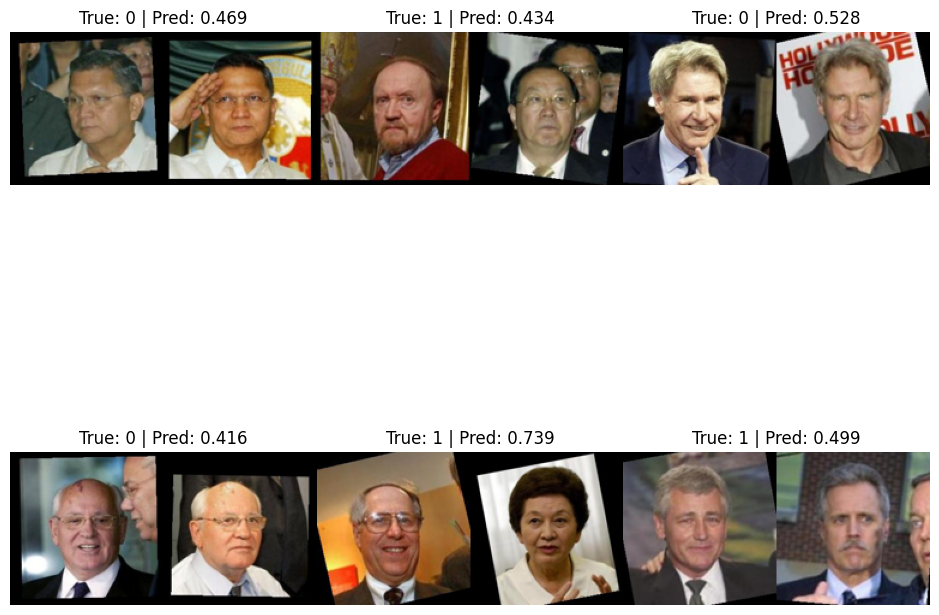

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    if to_show == 1:
        axes = [axes]
    if num_row > 1 and num_col > 1:
        axes = axes.flatten()

    for i in range(to_show):
        ax = axes[i]
        # We need to de-normalize the images from ResNet's [-1, 1] to [0, 1] for correct plotting
        img_pair_to_show = (pairs[i] / 2.0) + 0.5
        ax.imshow(ops.concatenate([img_pair_to_show[0], img_pair_to_show[1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.3f}".format(int(labels[i]), predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(int(labels[i])))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    # plt.tight_layout()
    plt.show()

predictions = siamese_model.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=6, predictions=predictions, test=True)

# Triplet Loss

## Setup

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras import ops
from keras import layers
from keras import optimizers
from keras import metrics
from keras import Model
import tensorflow as tf

# Load LFW Data and Create Triplets

In [ ]:
def create_lfw_triplets_in_memory(image_dir, pairs_path, target_shape):
    """
    Parses the LFW pairs file to create anchor, positive, and negative triplets,
    loading all images into memory as NumPy arrays.
    """
    anchor_images = []
    positive_images = []
    negative_images = []

    # Get a list of all available images for easy negative sampling
    all_image_paths = []
    for dirpath, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(dirpath, filename))

    # Open the CSV file and read it line by line
    with open(pairs_path, 'r') as f:
        next(f)  # Skip header
        positive_paths = []
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 3 or (len(parts) == 4 and parts[3] == ''):
                person, img_num1, img_num2 = parts[0], int(parts[1]), int(parts[2])
                path1 = os.path.join(image_dir, person, f"{person}_{img_num1:04d}.jpg")
                path2 = os.path.join(image_dir, person, f"{person}_{img_num2:04d}.jpg")
                positive_paths.append((path1, path2, person))

    print(f"Found {len(positive_paths)} positive pairs. Creating triplets...")

    for anchor_path, positive_path, person_name in positive_paths:
        try:
            # Find a random negative image from a DIFFERENT person
            negative_path = random.choice(all_image_paths)
            while person_name in negative_path:
                negative_path = random.choice(all_image_paths)

            # Load and process images
            anchor_img = np.array(Image.open(anchor_path).convert("RGB").resize(target_shape), dtype="float32")
            positive_img = np.array(Image.open(positive_path).convert("RGB").resize(target_shape), dtype="float32")
            negative_img = np.array(Image.open(negative_path).convert("RGB").resize(target_shape), dtype="float32")

            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)
        except FileNotFoundError:
            print(f"Warning: A file was not found for person {person_name}. Skipping triplet.")
            continue

    print("Image loading complete.")
    return (np.array(anchor_images), np.array(positive_images), np.array(negative_images))

# This will take significant time and memory
(anchors, positives, negatives) = create_lfw_triplets_in_memory(IMAGE_DIR, PAIRS_FILE, TARGET_SHAPE)

# Shuffle the data before splitting
p = np.random.permutation(len(anchors))
anchors, positives, negatives = anchors[p], positives[p], negatives[p]

# Create a Train/Validation split (e.g., 80% for train, 20% for val)
split_index = int(0.8 * len(anchors))
anchors_train, positives_train, negatives_train = anchors[:split_index], positives[:split_index], negatives[:split_index]
anchors_val, positives_val, negatives_val = anchors[split_index:], positives[split_index:], negatives[split_index:]

print(f"\nTotal triplets created: {len(anchors)}")
print("---")
print(f"Training triplets:   {len(anchors_train)}")
print(f"Validation triplets: {len(anchors_val)}")
print("---")
print(f"Shape of training anchors array: {anchors_train.shape}")

Found 3000 positive pairs. Creating triplets...
Image loading complete.

Total triplets created: 3000
---
Training triplets:   2400
Validation triplets: 600
---
Shape of training anchors array: (2400, 128, 128, 3)


## Preprocess the Image Data

In [ ]:
from keras.applications.resnet_v2 import preprocess_input

# Apply ResNetV2 preprocessing
anchors_train = preprocess_input(anchors_train)
positives_train = preprocess_input(positives_train)
negatives_train = preprocess_input(negatives_train)

anchors_val = preprocess_input(anchors_val)
positives_val = preprocess_input(positives_val)
negatives_val = preprocess_input(negatives_val)

## Define the Embedding Network Model

In [ ]:
def create_embedding_network(input_shape):
    # Define the ResNet50V2 base model
    base_cnn = keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    # Set layers to be trainable as requested
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    # Add a custom head for embedding generation
    flatten = keras.layers.Flatten()(base_cnn.output)
    dense1 = keras.layers.Dense(512, activation="relu")(flatten)
    dense1 = keras.layers.BatchNormalization()(dense1)
    output = keras.layers.Dense(256)(dense1) # 256-dimensional embedding

    return keras.Model(base_cnn.input, output, name="Embedding")

# Define the input shape for our LFW images
input_shape = TARGET_SHAPE + (3,)
embedding_network = create_embedding_network(input_shape)

## Setup the Siamese Network Model

In [ ]:
anchor_input = layers.Input(name="anchor", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)

# Generate the embeddings for the anchor, positive, and negative images
# by reusing the same embedding network instance.
embedded_anchor = embedding_network(anchor_input)
embedded_positive = embedding_network(positive_input)
embedded_negative = embedding_network(negative_input)

# The siamese network is a model that takes 3 images and returns 3 embeddings
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=[embedded_anchor, embedded_positive, embedded_negative]
)

## Create the Custom SiameseModel Class for Training

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # CORRECTION: Keras wraps the input tuple in another tuple.
        # We need to unpack it here. `x` will be our tuple of (anchor, pos, neg).
        x = data[0]

        with tf.GradientTape() as tape:
            loss = self._compute_loss(x)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # CORRECTION: Same change as in train_step.
        x = data[0]
        loss = self._compute_loss(x)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # This function is now correct because 'data' is the tuple of inputs.
        anchor, positive, negative = data

        anchor_embedding, positive_embedding, negative_embedding = self.siamese_network(
            [anchor, positive, negative]
        )

        ap_distance = ops.sum(ops.square(anchor_embedding - positive_embedding), axis=-1)
        an_distance = ops.sum(ops.square(anchor_embedding - negative_embedding), axis=-1)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return tf.reduce_mean(loss)

    @property
    def metrics(self):
        return [self.loss_tracker]

## Compile and Train the Model

In [ ]:
siamese_model = SiameseModel(siamese_network, margin=margin)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

history = siamese_model.fit(
    x=(anchors_train, positives_train, negatives_train),
    y=None,
    validation_data=((anchors_val, positives_val, negatives_val), None),
    batch_size=batch_size,
    epochs=epochs,
)

## Visualize Training Results

In [ ]:
def plt_metric(history, metric, title):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper right")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

plt_metric(history=history, metric="accuracy", title="Model Accuracy")

plt_metric(history=history, metric="loss", title="Triplet Loss")

## Visualize a Sample of Triplets

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""
    def show(ax, image):
        # De-normalize from ResNet's [-1, 1] to the original [0, 255] for display
        image = ((image + 1) * 127.5).astype(np.uint8)
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    fig.suptitle("Anchor | Positive | Negative", fontsize=16)
    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])
    plt.show()
# visualize()

In [ ]:
import numpy as np
from keras.applications.resnet_v2 import preprocess_input

# --- Step 1: Select a sample of triplets and visualize them ---
num_samples = 3
sample_anchors = anchors_val[:num_samples]
sample_positives = positives_val[:num_samples]
sample_negatives = negatives_val[:num_samples]

print("Showing a sample of triplets from the validation set:\n")
# We use your existing visualize function with the un-preprocessed images
visualize(sample_anchors, sample_positives, sample_negatives)


# --- Step 2: Preprocess the sample images for prediction ---
anchors_preprocessed = preprocess_input(sample_anchors.astype("float32"))
positives_preprocessed = preprocess_input(sample_positives.astype("float32"))
negatives_preprocessed = preprocess_input(sample_negatives.astype("float32"))


# --- Step 3: Generate embeddings for the sample ---
# We use the standalone embedding_network for this
anchor_embedding = embedding_network.predict(anchors_preprocessed)
positive_embedding = embedding_network.predict(positives_preprocessed)
negative_embedding = embedding_network.predict(negatives_preprocessed)


# --- Step 4: Calculate distances and print the results ---
print("\n--- Calculated Distances for the Triplets Above ---")
for i in range(num_samples):
    # Calculate the squared Euclidean distances (as used in the loss function)
    ap_distance = np.sum(np.square(anchor_embedding[i] - positive_embedding[i]))
    an_distance = np.sum(np.square(anchor_embedding[i] - negative_embedding[i]))

    print(f"\nTriplet {i+1}:")
    print(f"  Anchor-Positive Distance: {ap_distance:.4f}")
    print(f"  Anchor-Negative Distance: {an_distance:.4f}")
    if ap_distance < an_distance:
        print("  Result: Correctly separated!")
    else:
        print("  Result: Incorrectly separated.")

## Model performance in terms of cosine similarity

In [ ]:
import tensorflow as tf
from keras import metrics

# Let's pick a sample from the validation dataset to check the similarity.
# We'll use a batch to get a representative sample.
sample_anchors = anchors_val[:batch_size]
sample_positives = positives_val[:batch_size]
sample_negatives = negatives_val[:batch_size]

# Generate embeddings for the sample triplets using the siamese_network.
# The network was defined to output a list of three tensors:
# [anchor_embeddings, positive_embeddings, negative_embeddings]
anchor_embedding, positive_embedding, negative_embedding = siamese_network.predict(
    [sample_anchors, sample_positives, sample_negatives]
)

# Instantiate the CosineSimilarity metric
cosine_similarity = metrics.CosineSimilarity()

# Calculate the similarity between the anchor and the positive embeddings
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

# Calculate the similarity between the anchor and the negative embeddings
negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

# For a more concise view, we can also print the average similarity
print("\nAverage positive similarity:", np.mean(positive_similarity.numpy()))
print("Average negative similarity:", np.mean(negative_similarity.numpy()))

## Binary Cross-Entropy

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

def create_embedding_network(input_shape):
    # Define the ResNet50V2 base model
    base_cnn = keras.applications.ResNet50V2(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    # Set layers to be trainable as requested
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    # Add a custom head for embedding generation
    flatten = keras.layers.Flatten()(base_cnn.output)
    dense1 = keras.layers.Dense(512, activation="relu")(flatten)
    dense1 = keras.layers.BatchNormalization()(dense1)
    output = keras.layers.Dense(256)(dense1) # 256-dimensional embedding

    return keras.Model(base_cnn.input, output, name="Embedding")

# Define the input shape for our LFW images
input_shape = TARGET_SHAPE + (3,)
embedding_network = create_embedding_network(input_shape)

# The Siamese network structure is IDENTICAL to the blog's
input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese_model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
siamese_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)
siamese_model.summary()

In [ ]:
history = siamese_model.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

## Visualize Results

In [ ]:
def plt_metric(history, metric, title):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Plot the accuracy
plt_metric(history=history, metric="accuracy", title="Model Accuracy")

# Plot the loss
plt_metric(history=history, metric="loss", title="Binary Cross-Entropy Loss")

## Evaluate the Model on the Test Set

In [ ]:
results = siamese_model.evaluate([x_test_1, x_test_2], labels_test, batch_size=batch_size)
print("\nTest Loss, Test Acc:", results)

## Visualize Predictions

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step


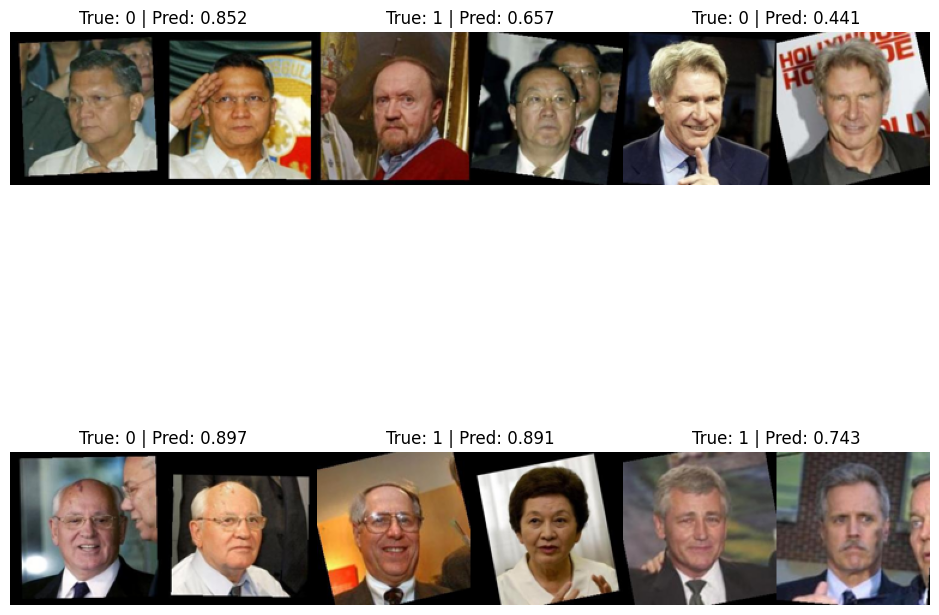

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    if to_show == 1:
        axes = [axes]
    if num_row > 1 and num_col > 1:
        axes = axes.flatten()

    for i in range(to_show):
        ax = axes[i]
        # De-normalize the images from ResNet's [-1, 1] to [0, 1] for correct plotting
        img_pair_to_show = (pairs[i] / 2.0) + 0.5
        ax.imshow(ops.concatenate([img_pair_to_show[0], img_pair_to_show[1]], axis=1))
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.3f}".format(int(labels[i]), predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(int(labels[i])))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# Make predictions on the preprocessed test set
predictions = siamese_model.predict([x_test_1, x_test_2])

# For visualization, use the original, un-preprocessed images from `pairs_test`
visualize(pairs_test, labels_test, to_show=6, predictions=predictions, test=True)

# Comparing the effect of Binary Cross-Entropy (BCE) loss and Mean Squared Error (MSE) as a reconstruction loss during training of a Variational Autoencoder (VAE).

## Setup and Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, Model
from keras import backend as K
import matplotlib.pyplot as plt

# Load the dataset
from keras.datasets import mnist

## Load and Preprocess the MNIST Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


## Building the VAE Model Components

In [ ]:
import tensorflow as tf
from keras import layers, Input, Model

LATENT_DIM = 2
IMAGE_SHAPE = (28, 28, 1)

# --- Encoder Architecture ---
encoder_inputs = Input(shape=IMAGE_SHAPE)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(x)

# --- MODIFICATION: Updated sampling function ---
# Replace Keras Backend (K) functions with TensorFlow (tf) functions
def sampling(args):
    z_mean, z_log_var = args
    # Use tf.shape() instead of K.shape()
    batch = tf.shape(z_mean)[0]
    # Use z_mean.shape[1] for static shape or tf.shape for dynamic
    dim = tf.shape(z_mean)[1]
    # Use tf.random.normal instead of K.random_normal
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

# --- Decoder Architecture ---
decoder_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

print("Encoder and Decoder architectures are ready.")

Encoder and Decoder architectures are ready.


## Defining a Flexible VAE Model

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type='bce', **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        # Trackers
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def _calculate_loss(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        if self.loss_type == 'bce':
            reconstruction_loss_tensor = keras.losses.binary_crossentropy(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(reconstruction_loss_tensor, axis=(1, 2)))

        elif self.loss_type == 'mse':
            # --- MODIFICATION: Instantiate the MSE class with reduction="none" ---
            # This makes it return a tensor of the same shape as the input (pixel-wise errors).
            mse_loss_fn = keras.losses.MeanSquaredError(reduction="none")
            reconstruction_loss_tensor = mse_loss_fn(data, reconstruction)
            # Now we can safely perform the same reduction as we did for BCE.
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(reconstruction_loss_tensor, axis=(1,2)))
        else:
            raise ValueError(f"Unknown loss_type: {self.loss_type}")

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

print("Flexible VAE model class defined.")

Flexible VAE model class defined.


## Train the VAE with Binary Cross-Entropy (BCE) Loss

In [ ]:
print("\n--- Training VAE with BCE Loss ---")

# Create fresh instances of the encoder and decoder for this model
encoder_bce = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder_bce')
decoder_bce = Model(decoder_inputs, decoder_outputs, name='decoder_bce')
vae_bce = VAE(encoder_bce, decoder_bce, loss_type='bce')

vae_bce.compile(optimizer=keras.optimizers.Adam())
history_bce = vae_bce.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None), verbose=1)

## Train the VAE with Mean Squared Error (MSE) Loss

In [ ]:
print("\n--- Training VAE with MSE Loss ---")

# It's crucial to create new models to train from scratch for a fair comparison
encoder_mse = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder_mse')
decoder_mse = Model(decoder_inputs, decoder_outputs, name='decoder_mse')
vae_mse = VAE(encoder_mse, decoder_mse, loss_type='mse')

vae_mse.compile(optimizer=keras.optimizers.Adam())
history_mse = vae_mse.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None), verbose=1)

## Generate Predictions from Both Models

In [ ]:
# Select sample images for reconstruction visualization
n = 10
sample_images = x_test[:n]

# Generate reconstructions from both models
reconstructed_bce = vae_bce.predict(sample_images)
reconstructed_mse = vae_mse.predict(sample_images)

# Generate latent space representations for the entire test set
z_mean_bce, _, _ = vae_bce.encoder.predict(x_test, batch_size=128)
z_mean_mse, _, _ = vae_mse.encoder.predict(x_test, batch_size=128)

## Compare Reconstructed Images

In [ ]:
plt.figure(figsize=(15, 6))
plt.suptitle("VAE Reconstruction Comparison: BCE vs. MSE", fontsize=16)

for i in range(n):
    # Original Image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # BCE Reconstructed Image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_bce[i].reshape(28, 28), cmap='gray')
    ax.set_title("BCE Recon")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # MSE Reconstructed Image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(reconstructed_mse[i].reshape(28, 28), cmap='gray')
    ax.set_title("MSE Recon")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Compare Latent Space Visualizations

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("VAE Latent Space Comparison: BCE vs. MSE", fontsize=16)

# Latent Space from BCE-trained VAE
scatter1 = ax1.scatter(z_mean_bce[:, 0], z_mean_bce[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.7)
ax1.set_xlabel("Latent Dimension 1")
ax1.set_ylabel("Latent Dimension 2")
ax1.set_title("Latent Space (BCE Loss)")
ax1.grid(True)
fig.colorbar(scatter1, ax=ax1, label='Digit Class')

# Latent Space from MSE-trained VAE
scatter2 = ax2.scatter(z_mean_mse[:, 0], z_mean_mse[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.7)
ax2.set_xlabel("Latent Dimension 1")
ax2.set_ylabel("Latent Dimension 2")
ax2.set_title("Latent Space (MSE Loss)")
ax2.grid(True)
fig.colorbar(scatter2, ax=ax2, label='Digit Class')

plt.show()